#Unsupervised Classification of Salesforce Help Articles
**Thomas Bohn**   --   **2024-10-03**

A report focused on modeling tags (categorization) for Salesforce help documentation focused on the application of natural language processing, unsupervised learning with matrix factorization, and a comparison to supervised learning.

--  [Main Report](https://github.com/TOM-BOHN/MsDS-unsupervised-nlp-sfdc-classification/blob/main/unsupervised-nlp-sfdc-classification.ipynb)  --  [Github Repo](https://github.com/TOM-BOHN/MsDS-unsupervised-nlp-sfdc-classification)  --  [Presentation Slides](TBD)  --  [Presentation Video](TBD) --

# 1.&nbsp;Introduction

**Background**
Text documents are one of the richest sources of data for businesses. By using Natural Language Processing (NLP) features can be created for supervised and unsupervised models. Unsupervised models are typically better at handling the larve volume of features created from text documents. [1]

**Data Source**
Use a public dataset from the BBC comprised of 2225 articles. More details on the datasource can be found here: [learn ai bbc](https://www.kaggle.com/competitions/learn-ai-bbc/overview) [1].


**Categories**
The articles are labeled under one of 5 categories:
- business
- entertainment
- politics
- sport
- tech

**Overview of Observations**
The dataset is broken into 1490 records for training and 735 for testing. Each observation is the full text of the article with an associated article id [1]. The text files need to be broaken out into features. The training dataset indicates the category. No category is provided for the test dataset.

**Objective**
The objective is to build an unsupervised Non-Negative Matrix Factorization (NMF) model. The model should be capable of accurately classify previously unseen news articles into one of the five categories. FInal evaluation will use Accuracy as a metric.

**Report Overview**
The project will cover 5 key phases:
1. Exploratory Data Analysis (EDA)
2. Data Cleaning
3. Extracting Word Features with Natural Language Processing (MLP) Tools
4. Building and Training an Unsupervised Non-Negative Matrix Factorization (NMF) Model
5. Build and Compare a Random Forest Supervised Learning Model

## Python Libraries

The following python libraries are used in this notebook.

In [1]:
# File system manangement
import time, datetime, psutil, os

# Basic Data Science Toolkits
import pandas as pd
import numpy as np
import math
import random
import itertools as it

# Install text storage and manipulation
import json
import pickle
import textwrap
import string

##################################

# Plotting and visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
from matplotlib import ticker
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# NLP
import string, re, nltk
from string import punctuation
from string import digits
import nltk.corpus
from nltk.corpus import stopwords
from nltk.corpus import wordnet
!pip install num2words
from num2words import num2words
!pip install pyspellchecker
from spellchecker import SpellChecker
import spacy

# NLP Tokenizer and Lemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Feature Engineering
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Data Model Unsupervised NFM
import sklearn
from sklearn.decomposition import NMF

# Data Models Unsupervised RF
import sklearn
from sklearn.ensemble import RandomForestClassifier

# Import Data Model Evaluations
from sklearn.model_selection import train_test_split, ParameterGrid

# Cross Validation, Grid Search, and K-Fold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# Model evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 5.2 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=1fbe9888bc99baf46213b71d3830a5bdd4d98798904e76ed8fbe22fc68ec24dc
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 81.7 MB/s eta 0:00:00


## Installing NLTK Data

In [2]:
#Install the necessary datasets/models for specific functions to work
nltk.download('popular', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

## Global Variables

The following are global variables referenced in this notebook.

In [3]:
# Global Debug flag used to turn on and off more chatty blocks of code
gDEBUG = False
if gDEBUG: print('Debug is set to:', gDEBUG)
# Global Level of Detail of table stats and details
gLOD = 2
print('Level of Detail for functions is set to:', gLOD)

Level of Detail for functions is set to: 2


# 2.&nbsp;Data Source

## Import the Data

In [4]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

file_path_root = '/content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5506 Data Mining Presentation/data'
file_path_sales   = file_path_root + '/sales_core_df.pickle'
file_path_service = file_path_root + '/service_cloud_df.pickle'


# Load the Service Data From Pickle
with open(file_path_service, 'rb') as f:
  data_service = pickle.load(f)
# Load the Sales Data From Pickle
with open(file_path_sales, 'rb') as f:
  data_sales = pickle.load(f)

Mounted at /content/drive


In [5]:
# Preview the Data Sources
display(data_service.head(1))
display(data_sales.head(1))

,index,aria-level,title,id,href,parent,l0_id,l1_id,l2_id,l3_id,...,l1_title,l2_title,l3_title,l4_title,l5_title,l6_title,l7_title,l8_title,url,text
0,0,0,Service Cloud,service_cloud_leaf,/s/articleView?id=sf.service_cloud.htm&languag...,None,service_cloud_leaf,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://help.salesforce.com/s/articleView?id=s...,Service Cloud Give your customers the informat...


,index,aria-level,title,id,href,parent,l0_id,l1_id,l2_id,l3_id,...,l0_title,l1_title,l2_title,l3_title,l4_title,l5_title,l6_title,l7_title,url,text
0,0,0,Sales Cloud Basics,sales_core_leaf,/s/articleView?id=sf.sales_core.htm&language=e...,None,sales_core_leaf,NaN,NaN,NaN,...,Sales Cloud Basics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://help.salesforce.com/s/articleView?id=s...,Sales Cloud Basics The Sales Cloud provides ev...


## Data Preparation

In [6]:
# Find the set of different columns between the two DataFrames
different_columns = set(data_sales.columns) ^ set(data_service.columns)

print("Columns to dropped from tables:", list(different_columns))

# Drop the columns in the difference from both DataFrames
data_sales = data_sales.drop(columns=list(different_columns.intersection(set(data_sales.columns))))
data_service = data_service.drop(columns=list(different_columns.intersection(set(data_service.columns))))

print("Drop Completed.\n")

print("Merging 2 Data Sources.\n")

# Union the 2 tables together to make a single table of data
if list(data_sales.columns) == list(data_service.columns):
  # Merge the DataFrames
  data_merged = pd.concat([data_sales, data_service], ignore_index=True)

  # Specify the columns to keep
  columns_to_keep = ['aria-level', 'title', 'id', 'l0_id', 'l1_id',
                     'l2_id', 'l0_title', 'l1_title', 'l2_title', 'url', 'text']

  # Subset the DataFrame to keep only the specified columns
  data_merged = data_merged[columns_to_keep]

  # Summary of the shape of the data
  print(pd.Series({"Memory usage": "{:.2f} MB".format(data_merged.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data_merged.shape)}).to_string())

  # Print the DataFrame to the screen
  print("Columns in table:", list(data_merged.columns), "\n")
else:
  print("The columns in the two DataFrames are not the same. Cannot merge.\n")

#Example of the table created
print("Example of the table created:\n")
display(data_merged.head(3))

# Example of the text from the article
example_text = data_merged['text'].iloc[100]
# Print to Screen
print("\nExample of the text for each record:\n")
print("Length of Text:", len(example_text), "\n")
print(textwrap.fill(example_text, width=100))

Columns to dropped from tables: ['l8_id', 'l8_title']
Drop Completed.

Merging 2 Data Sources.

Memory usage        0.13 MB
Dataset shape    (1498, 11)
Columns in table: ['aria-level', 'title', 'id', 'l0_id', 'l1_id', 'l2_id', 'l0_title', 'l1_title', 'l2_title', 'url', 'text'] 

Example of the table created:



,aria-level,title,id,l0_id,l1_id,l2_id,l0_title,l1_title,l2_title,url,text
0,0,Sales Cloud Basics,sales_core_leaf,sales_core_leaf,NaN,NaN,Sales Cloud Basics,NaN,NaN,https://help.salesforce.com/s/articleView?id=s...,Sales Cloud Basics The Sales Cloud provides ev...
1,1,"Learn About, Implement, and Optimize Sales Clo...",sales_core_basics_leaf,sales_core_leaf,sales_core_basics_leaf,NaN,Sales Cloud Basics,"Learn About, Implement, and Optimize Sales Clo...",NaN,https://help.salesforce.com/s/articleView?id=s...,"Learn About, Implement, and Optimize Sales Clo..."
2,1,"See an Overview of Metrics, Goals, Suggestions...",sales_core_seller_home_leaf,sales_core_leaf,sales_core_seller_home_leaf,NaN,Sales Cloud Basics,"See an Overview of Metrics, Goals, Suggestions...",NaN,https://help.salesforce.com/s/articleView?id=s...,"See an Overview of Metrics, Goals, Suggestions..."



Example of the text for each record:

Length of Text: 901 

Manage Leads View, update, and convert leads as you build your pipeline. Lead Intelligence View View
lead activity and engagement metrics, see insights, take action, and update records all in one place
in the Lead Intelligence View. Leads List View Home Click the Leads tab to display the leads list
view home page or the Lead Intelligence View. Display and Edit Leads Display, edit leads details,
and share leads. Converting Leads After you qualify your leads, convert them to contacts, accounts,
and opportunities. Merge Duplicate Leads Keep your records clean and free of duplicates so you can
reach more customers and maintain better relationships with them. Reassign Leads from a Queue
Accepting leads from a queue is an easy way to reassign leads to yourself. Lead Sharing in
Salesforce Classic Extend sharing privileges beyond the basic sharing model for your own data on a
lead-by-lead basis.


## Address Missing Values

In [7]:
# Missing values and duplicate observations
print(pd.Series({"Number of observations with missing values": len(data_merged) - len(data_merged.dropna()),
                 "Number of duplicate observations": data_merged.duplicated().sum()}).to_string())

# Dropping observations with missing valuesd
data_merged.dropna(inplace = True)
# Dropping duplicate observations
data_merged.drop_duplicates(inplace = True)
# Resetting index
data_merged.reset_index(drop = True, inplace = True)

# Group the data by l0_id and count the number of records
summary_table = data_merged.groupby(['l0_id'])['id'].count().reset_index(name='record_count')

# Create a table with a count of each unique label for each group
for col in ['l0_id', 'l1_id', 'l2_id']:
  summary_table = pd.merge(summary_table,
                           data_merged.groupby(['l0_id'])[col].nunique().reset_index(name=f'{col}_label_count'),
                           on=['l0_id'], how='left')

# Display the Summary Table
print("\nSummary Table of Tags Counts:\n")
display(summary_table)

# Group by l0_id and l1_id and count the number of records in each group
summary_table = data_merged.groupby(['l0_id', 'l1_id']).size().reset_index(name='record_count')

# Display the Summary Table
print("\nSummary Table of Records Per Tag:\n")
display(summary_table)

Number of observations with missing values    26
Number of duplicate observations               2

Summary Table of Tags Counts:



,l0_id,record_count,l0_id_label_count,l1_id_label_count,l2_id_label_count
0,sales_core_leaf,646,1,7,33
1,service_cloud_leaf,824,1,5,29



Summary Table of Records Per Tag:



,l0_id,l1_id,record_count
0,sales_core_leaf,sales_core_artificial_intelligence_parent_leaf,5
1,sales_core_leaf,sales_core_bring_in_leads_leaf,133
2,sales_core_leaf,sales_core_legacy_features_leaf,11
3,sales_core_leaf,sales_core_manage_accounts_contacts_leaf,99
4,sales_core_leaf,sales_core_manage_sales_team_leaf,275
5,sales_core_leaf,sales_core_salesforce_maps_lite_leaf,3
6,sales_core_leaf,sales_core_turn_opptys_into_deals_leaf,120
7,service_cloud_leaf,support_admins_intro_leaf,187
8,service_cloud_leaf,support_deflection_leaf,192
9,service_cloud_leaf,support_metrics_leaf,124


## Data Scoping Functions

In [8]:
def invert_dictionary(dictionary):
  if not isinstance(dictionary, dict):
    return None

  inverted_dictionary = {}
  for key, value in dictionary.items():
    if value not in inverted_dictionary:
      inverted_dictionary[value] = key
    else:
      if isinstance(inverted_dictionary[value], list):
        inverted_dictionary[value].append(key)
      else:
        inverted_dictionary[value] = [inverted_dictionary[value], key]

  return inverted_dictionary

def replace_labels(labels, label_dict):
  new_labels = []
  for label in labels:
    if label in label_dict:
      new_labels.append(label_dict[label])
    else:
      new_labels.append(label)

  return new_labels

In [9]:
def scope_data(data_input, label_col):

  # Specify the columns to keep
  columns_to_keep = ['id', label_col, 'text', 'title', 'url']

  # Subset the DataFrame to keep only the specified columns
  data = data_input[columns_to_keep]

  #rename the column lo_id to label
  data = data.rename(columns={label_col: 'label'})

  #Remove any labels that do not have data coverage
  threshold = 4
  label_counts = data['label'].value_counts()
  labels_to_drop = label_counts[label_counts <= threshold].index.tolist()

  if labels_to_drop:
    print(f"Dropping records belonging to labels with {threshold} or fewer records: {labels_to_drop}")
    data = data[~data['label'].isin(labels_to_drop)]
  else:
    print(f"No labels with {threshold} or fewer records found.")

  # Automatically encoding of labels
  label_dict = {}
  unique_labels = data['label'].unique()
  for i, label in enumerate(unique_labels):
    label_dict[label] = i
  # Create the inverse dictionary
  inverted_label_dict = invert_dictionary(label_dict)

  # Replace the labels with the encoded values
  data.replace({'label': label_dict}, inplace = True)

  # Summary of the shape of the data
  print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)),
                  "Dataset shape": "{}".format(data.shape)}).to_string())

  # Print the DataFrame to the screen
  print("Columns in table:", list(data.columns))

  return data, label_dict, inverted_label_dict

In [10]:
# Create a dictionary to store the data for each label
def create_data_by_label(data, label_col):
  data_by_label = {}
  # Iterate over the unique labels
  for label in data['label'].unique():
      # Subset the data for the current label
      data_by_label[label] = data[data['label'] == label]

  print("Size of the data by label dictionary:", len(data_by_label), "\n")

  return data_by_label

## Scope the Label and Text for Analysis

In [11]:
# Select the scope of data and label to target
scope = 'l1_id'
data, label_dict, inverted_label_dict = scope_data(data_merged, label_col = scope)
print("label_dictionary:", label_dict, "\n")

# Create the data by label structure
data_by_label = create_data_by_label(data, 'label')

# Display the scoped dataframe
display(data.head(3))

Dropping records belonging to labels with 4 or fewer records: ['sales_core_salesforce_maps_lite_leaf']
Memory usage       0.07 MB
Dataset shape    (1467, 5)
Columns in table: ['id', 'label', 'text', 'title', 'url']
label_dictionary: {'sales_core_bring_in_leads_leaf': 0, 'sales_core_turn_opptys_into_deals_leaf': 1, 'sales_core_manage_accounts_contacts_leaf': 2, 'sales_core_manage_sales_team_leaf': 3, 'sales_core_artificial_intelligence_parent_leaf': 4, 'sales_core_legacy_features_leaf': 5, 'support_admins_intro_leaf': 6, 'support_productivity_leaf': 7, 'support_deflection_leaf': 8, 'support_routing_automation_leaf': 9, 'support_metrics_leaf': 10} 

Size of the data by label dictionary: 11 



<ipython-input-9-fdb4b54be357>:32: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,id,label,text,title,url
0,campaigns_def_leaf,0,Get to Know Salesforce Campaigns Many cross-fu...,Get to Know Salesforce Campaigns,https://help.salesforce.com/s/articleView?id=s...
1,campaigns_tour_leaf,0,Tour the Campaigns Object To get familiar with...,Tour the Campaigns Object,https://help.salesforce.com/s/articleView?id=s...
2,campaigns_use_cases_leaf,0,How Campaigns Can Help You can use Salesforce ...,How Campaigns Can Help,https://help.salesforce.com/s/articleView?id=s...


# 3.&nbsp;Exploratory Data Analysis (EDA)

When exploring the data, the following explorations will be conducted:
- Review the distribution of categories
- Review the distribution of charecters in each article
- Review the distribution of words in each article

## Quick Table Details

In [12]:
# Create a function to print key table details
def quick_table_details (df_name, df, level_of_detail = 10):
  # describe the shape and column summary
  if level_of_detail >= 1:
    print('\n####', df_name, '####')
    num_rows = df.shape[0]
    num_cols = df.shape[1]
    print('number of features (columns) = ' + str(num_cols))
    print('number of observations (rows) = ' + str(num_rows))
    print('----------------------------', '\n')
  # print the datatype counts
  if level_of_detail >= 2:
    print('DataType Counts:')
    display(df.dtypes.value_counts())
    print('----------------------------', '\n')
  # print a full list of column names
  if level_of_detail >= 3:
    print('Columns:')
    print(df.columns)
    print('----------------------------', '\n')
  #  expanded table details
  if level_of_detail >= 4:
    print('Description:')
    display(df.describe(include='all'))
    print('----------------------------', '\n')
    print('Info:')
    display(df.info())
    print('----------------------------', '\n')
  #  table records preview
  if level_of_detail >= 5:
    print('Table Preview:')
    x_records = 3
    display(df.head(x_records))
    print('....')
    display(df.tail(x_records))
    print('----------------------------', '\n')


In [13]:
# Print summary details for the 3 tables in the datasource
quick_table_details ("data", data, level_of_detail = 10)


#### data ####
number of features (columns) = 5
number of observations (rows) = 1467
---------------------------- 

DataType Counts:


,count
object,4
int64,1


---------------------------- 

Columns:
Index(['id', 'label', 'text', 'title', 'url'], dtype='object')
---------------------------- 

Description:


,id,label,text,title,url
count,1467,1467.000000,1467,1467,1467
unique,1466,NaN,1458,1445,1466
top,leads_merge_considerations_leaf,NaN,Launching Your Service Catalog Site To go live...,In Salesforce Classic,https://help.salesforce.com/s/articleView?id=s...
freq,2,NaN,4,3,2
mean,NaN,5.219496,NaN,NaN,NaN
std,NaN,3.223520,NaN,NaN,NaN
min,NaN,0.000000,NaN,NaN,NaN
25%,NaN,3.000000,NaN,NaN,NaN
50%,NaN,6.000000,NaN,NaN,NaN
75%,NaN,8.000000,NaN,NaN,NaN


---------------------------- 

Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1467 entries, 0 to 1469
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1467 non-null   object
 1   label   1467 non-null   int64 
 2   text    1467 non-null   object
 3   title   1467 non-null   object
 4   url     1467 non-null   object
dtypes: int64(1), object(4)
memory usage: 68.8+ KB


None

---------------------------- 

Table Preview:


,id,label,text,title,url
0,campaigns_def_leaf,0,Get to Know Salesforce Campaigns Many cross-fu...,Get to Know Salesforce Campaigns,https://help.salesforce.com/s/articleView?id=s...
1,campaigns_tour_leaf,0,Tour the Campaigns Object To get familiar with...,Tour the Campaigns Object,https://help.salesforce.com/s/articleView?id=s...
2,campaigns_use_cases_leaf,0,How Campaigns Can Help You can use Salesforce ...,How Campaigns Can Help,https://help.salesforce.com/s/articleView?id=s...


....


,id,label,text,title,url
1467,monitor_article_automated_actions_leaf,10,Monitor Automated Article Process Actions Sale...,Article Process Actions,https://help.salesforce.com/s/articleView?id=s...
1468,reports_support_crts_leaf,10,Use Custom Report Types to Report on Support A...,Use Custom Report Types,https://help.salesforce.com/s/articleView?id=s...
1469,reports_support_tips_leaf,10,Tips for Effective Support Reporting You can g...,Support Reporting Tips,https://help.salesforce.com/s/articleView?id=s...


---------------------------- 



## Review the Distribution of Categories

In [14]:
#print column names for each table
print('columns in df_train:', data.columns)

columns in df_train: Index(['id', 'label', 'text', 'title', 'url'], dtype='object')


In [15]:
# function to count the number of records in each category and stats
def count_field(df, field = 'label'):
    df_cat_count = pd.DataFrame(df[field].value_counts()).reset_index()
    #df_cat_count = df_cat_count.rename(columns={'label': 'Count', 'index': 'Label'})
    df_cat_count = df_cat_count.sort_values(by = ['count'], ascending = False)
    df_cat_count['Pct of Total'] = round(df_cat_count['count'] / df_cat_count['count'].sum(), 2)
    df_cat_count['Pct of Total Text'] = (df_cat_count['Pct of Total'] * 100).apply(int).apply(str) + ' %'
    return df_cat_count

In [16]:
# calculate the count of records in each category
df_cat_count = count_field(df = data, field = 'label')

display(df_cat_count)

,label,count,Pct of Total,Pct of Total Text
0,3,275,0.19,19 %
1,8,192,0.13,13 %
2,6,187,0.13,13 %
3,7,174,0.12,12 %
4,9,147,0.10,10 %
5,0,133,0.09,9 %
6,10,124,0.08,8 %
7,1,120,0.08,8 %
8,2,99,0.07,7 %
9,5,11,0.01,1 %


In [17]:
# define a function to aggregate dataframe on a single category
def shape_df_for_stacked_barchart(df, group_by, stack_by, normalize=True):
    # Check if group_by and stack_by are the same
    if group_by == stack_by:
        # If they are the same, simply return the value counts as a DataFrame
        df_chart = df[group_by].value_counts(normalize=normalize).round(2).to_frame()
        df_chart.index.name = stack_by  # Set the index name for consistency
    else:
        # If they are different, proceed with the original logic
        df_chart = (df
                    .groupby(group_by)[stack_by]
                    .value_counts(normalize=normalize)
                    .round(2)
                    .unstack())
    return df_chart

# defgine a function to plot a bar chart for a single category
def create_single_stacked_bar(df, group_by, stack_by, fig_size = (5,5), normalize=True):
  df_chart = shape_df_for_stacked_barchart(df = df, group_by = group_by, stack_by = stack_by, normalize = normalize)
  if gDEBUG: print(df_chart, '\n')
  fig, ax = plt.subplots(figsize = fig_size)
  # plot the chart
  chart = df_chart.plot.bar(stacked = True,
                    ax = ax,
                    width = 0.3,
                    edgecolor = "black")
  # Customising legend
  ax.legend(fontsize = 10, title_fontsize = 10)

  ax.set_title(group_by, fontsize=10)
  ax.set_xlabel(group_by, fontsize=8)
  ax.set_ylabel('Record Count', fontsize=8)
  return fig

[-] the catgory of 3 makes up 19 % of the data.
[-] the catgory of 8 makes up 13 % of the data.
[-] the catgory of 6 makes up 13 % of the data.
[-] the catgory of 7 makes up 12 % of the data.
[-] the catgory of 9 makes up 10 % of the data.
[-] the catgory of 0 makes up 9 % of the data.
[-] the catgory of 10 makes up 8 % of the data.
[-] the catgory of 1 makes up 8 % of the data.
[-] the catgory of 2 makes up 7 % of the data.
[-] the catgory of 5 makes up 1 % of the data.
[-] the catgory of 4 makes up 0 % of the data.


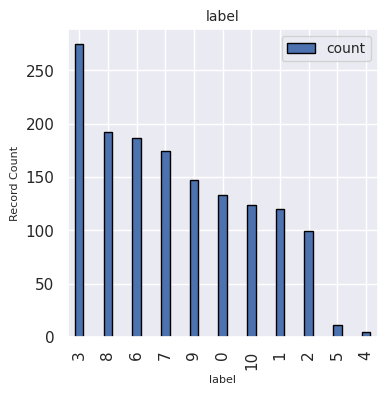

In [18]:
# Summarize the target in the dataset
chart = create_single_stacked_bar(df = data, group_by = 'label', stack_by = 'label', fig_size = (4,4), normalize = False)
table = shape_df_for_stacked_barchart(df = data, group_by = 'label', stack_by = 'label', normalize = False)
# Print a summary of the percent share of the total for each category
for i in range(len(df_cat_count)):
    # Changed 'Category' to 'Label' to access the correct column
    print('[-] the catgory of', df_cat_count['label'].iloc[i], 'makes up',
           df_cat_count['Pct of Total Text'].iloc[i], 'of the data.')

The data is somewhat skewered. There are significantly more records in label 3, very few records in labels 4 and 5, and approximately the same number of records in the other labels. We may need to use balancing hyper-parameters in our models to address the uneven sample size across labels (categories).

## Review of the Text

Text(0, 0.5, 'Record Count')

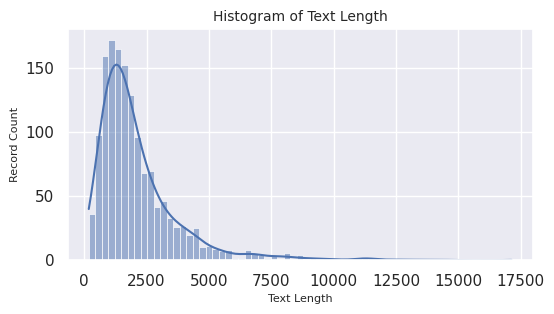

In [19]:
# add a length column to the dataframe
data['text length (text)'] = data['text'].apply(len)
#create a figure
fig, ax = plt.subplots(figsize = (6,3))
# create a histogram of the length of text
#chart = plt.hist(x = df_s['Text Length'])
chart = sns.histplot(x = data['text length (text)'], kde=True)
# Customising legend
ax.set_title('Histogram of Text Length', fontsize=10)
ax.set_xlabel('Text Length', fontsize=8)
ax.set_ylabel('Record Count', fontsize=8)

There is a slight skew to the the lenght of the articles with a very long tail extending up to some very large values. Further analysis should be conducted to determine if there are outliers.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning:

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.



Text(0.5, 1.0, 'Boxplot of Text Length')

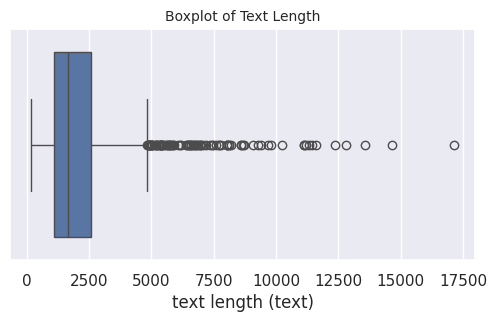

In [20]:
# add a length column to the dataframe
data['text length (text)'] = data['text'].apply(len)
#create a figure
fig, ax = plt.subplots(figsize = (6,3))
# create a boxplot of the length of text
chart = sns.boxplot(x = data['text length (text)'])
ax.set_title('Boxplot of Text Length', fontsize=10)

Reviewing a box plot, it is clear that many documentation items are candidates for outliers. A cutoff point will need to be identified, and outlier articles on length can be considered for dropping in the data cleansing steps.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning:

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.



Text(0.5, 1.0, 'Boxplot of Word Count')

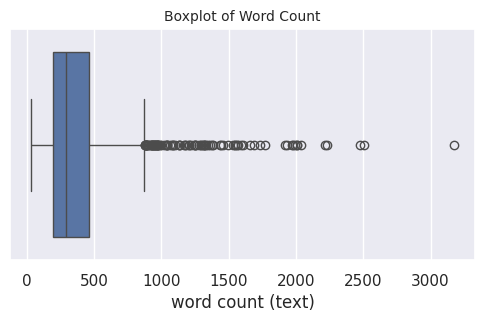

In [21]:
# define a function to add the word count to a dataframe
def add_word_count(df):
    df['text tokens'] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
    df['word count (text)'] = df['text tokens'].apply(len)
    df.drop(columns = ['text tokens'], inplace=True)
    return df
# add a length column to the dataframe for wordcount
data = add_word_count(df = data)
#create a figure
fig, ax = plt.subplots(figsize = (6,3))
# create a boxplot of the length of text
chart = sns.boxplot(x = data['word count (text)'])
ax.set_title('Boxplot of Word Count', fontsize=10)

Revieweing the wordcount, we see a similar pattern displayed. Again, we should consider removing some the outlier values with large word counts relative the rest of the articles.

In [22]:
# show the content of one Article in the data source
print(data['text'][55])

Add or Update Campaign Members with the Data Import Wizard To add or update many campaign members at once, launch the Data Import Wizard from the campaign detail page. and User Permissions Available in: Salesforce Classic (not available in all orgs) and Lightning Experience Available in: Salesforce Professional, Enterprise, Performance, Unlimited, and Developer Editions User Permissions Needed To add or update campaign members via the Data Import Wizard: Marketing User selected in your user information AND Read on contacts OR Import Leads AND Edit on campaigns Tip To obtain Salesforce IDs or other values from your org, run reports and then export the report data. Before you begin, make sure that your import file is in CSV format and contains values for these fields. Salesforce ID of the contact or lead. For person accounts, use the contact ID associated with the person account as the Salesforce ID. Status of the campaign member Campaign ID (if you’re on a non-campaign page and want to 

The text included in the documentation field appears to be unformatted documentation text. The removal of most formatting is a biproduct of the text scrapping process. It includes punctuation, common articles and connecting words, and conjugated or derivatives of a base word. The text will need to be cleansed to ensure it is prepared for modeling. An effort should be made to remove articles and punctuation that could add noise to the model. Words should be simplified to their base forms to ensure they can be properly matched.

## Results of EDA

After completing the initial exploratory data analysis and details related to the table, there are several data cleansing activities that could potentially improve data source. These include:
- Checking for null values
- Cleaning the text field that describes the documentation
 - Removal of http and html
 - Removal of punctuation
 - Removal of emojis
 - Convert acronyms and contractions
 - Discard non-alphabetical charecters
 - Remove a custom list of stopwords
- Remove any outliers based on word count or documentation length
- Lemmatization of the text

# 4. Train-Validation-Test Split

## Test Split Functions

In [23]:
# Feature-target split
def training_test_split(data, test_size = 0.2):

  # Feature-target split
  X, y = data.drop(['label'], axis = 1), data['label']

  # Train-test split (from complete data)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, stratify=y, random_state = 55)
  data_train = pd.concat([X_train, y_train], axis = 1)

  # Validation-test split (from test data)
  X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 55)
  data_val, data_test = pd.concat([X_val, y_val], axis = 1), pd.concat([X_test, y_test], axis = 1)

  print("Size of the training set:", len(data_train))
  print("Size of the validation set:", len(data_val))
  print("Size of the test set:", len(data_test))
  print()
  print("Labels in training set:", data_train['label'].nunique())
  print("Labels in validation set:", data_val['label'].nunique())
  print("Labels in test set:", data_test['label'].nunique())
  print()
  print("Columns in test set:", data_test.columns)
  print()


  # Create a histogram for the count of records in each label
  label_counts = data['label'].value_counts()
  plt.figure(figsize=(5, 3))
  plt.bar(label_counts.index.astype(str), label_counts.values)
  plt.xlabel('Label')
  plt.ylabel('Number of Records')
  plt.title('Distribution of Records Across Labels')
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
  plt.tight_layout()
  plt.show()

  print()

  # Comparison of sizes of training set, validation set and test set
  values = np.array([len(data_train), len(data_val), len(data_test)])
  labels = ['Training Set', 'Validation Set', 'Test Set']

  # Create the pie chart with a hole for the donut effect
  plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4), pctdistance=0.85)

  # Add a circle at the center to create the donut hole
  centre_circle = plt.Circle((0, 0), 0.70, fc='white')
  fig = plt.gcf()
  fig.gca().add_artist(centre_circle)

  # Set the title
  plt.title("Comparison of sizes of training set, validation set and test set")

  # Ensure the circle's proportion is correct
  plt.axis('equal')

  # Display the chart
  plt.show()

  #Return Splot Data
  return data_train, data_val, data_test

## Test Split Analysis

Size of the training set: 1173
Size of the validation set: 147
Size of the test set: 147

Labels in training set: 11
Labels in validation set: 10
Labels in test set: 10

Columns in test set: Index(['id', 'text', 'title', 'url', 'text length (text)', 'word count (text)',
       'label'],
      dtype='object')



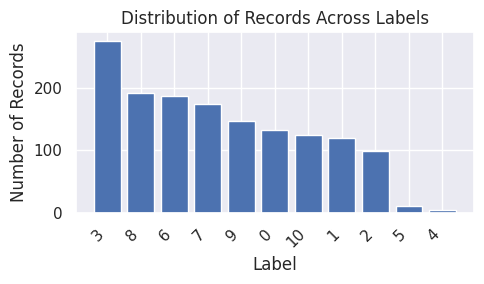

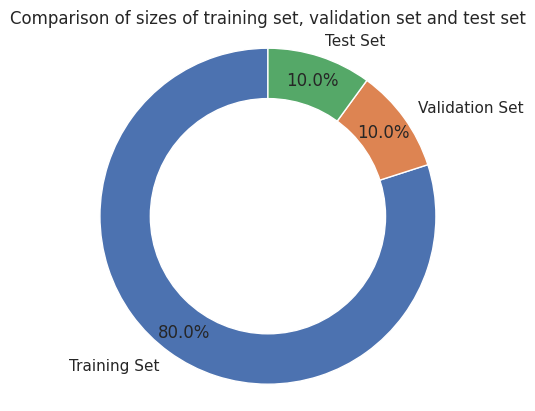

In [24]:
# Feature-target split
data_train, data_val, data_test = training_test_split(data, test_size = 0.2)

# 5.&nbsp;Data Cleansing

Data cleaning identified in the exploratory data analysis will be executed in this section.

## Check for Null Values

In [25]:
# Inspect observations (rows) with null values
def count_all_rows_with_null(df):
  df_null = df.isnull()
  df_null['null_count'] = df_null.sum(axis=1)
  df_null['null_flag'] = df_null['null_count'].apply(lambda x: 1 if x > 0 else 0)

  df_null = df_null[df_null['null_count'] > 0]
  print("Data", 'count of observations with nulls:',df_null['null_flag'].sum())

In [26]:
# Count all null records
count_all_rows_with_null(df = data_train)
count_all_rows_with_null(df = data_val)
count_all_rows_with_null(df = data_test)

Data count of observations with nulls: 0
Data count of observations with nulls: 0
Data count of observations with nulls: 0


## Clean Text for Modeling

In [27]:
#Track a list of the descriptions and the function names
tn_funct = []; tn_desc = []

# RegexpTokenizer
regexp = RegexpTokenizer("[\w']+")

# Converting to lowercase
def convert_to_lowercase(text):
    return text.lower()

tn_funct.append('convert_to_lowercase(text)')
tn_desc.append('Converting to lowercase')
print('Testing', tn_funct[-1], "...")
text = "This is a FUNCTION that CoNvErTs a Text to lowercase"
print("Input: {}".format(text))
print("Output: {}".format(convert_to_lowercase(text)))
print()

# Removing whitespaces
def remove_whitespace(text):
    return text.strip()

tn_funct.append('remove_whitespace(text)')
tn_desc.append('Removing whitespaces')
print('Testing', tn_funct[-1], "...")
text = " \t This is a string \t "
print("Input: {}".format(text))
print("Output: {}".format(remove_whitespace(text)))
print()

# Removing punctuations
def remove_punctuation(text):
    punct_str = string.punctuation
    punct_str = punct_str.replace("'", "") # discarding apostrophe from the string to keep the contractions intact
    return text.translate(str.maketrans("", "", punct_str))

tn_funct.append('remove_punctuation(text)')
tn_desc.append('Removing punctuations')
print('Testing', tn_funct[-1], "...")
text = "Here's [an] example? {of} &a string. with.? punctuations!!!!"
print("Input: {}".format(text))
print("Output: {}".format(remove_punctuation(text)))
print()

# Removing HTML tags
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

tn_funct.append('remove_html(text)')
tn_desc.append('Removing HTML tags')
print('Testing', tn_funct[-1], "...")
text = ' Ecommerce Text Classification '
print("Input: {}".format(text))
print("Output: {}".format(remove_html(text)))
print()

# Removing emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    return emoji_pattern.sub(r'', text)

tn_funct.append('remove_emoji(text)')
tn_desc.append('Removing emojis')
print('Testing', tn_funct[-1], "...")
text = "This innovative hd printing technique results in durable and spectacular looking prints 😊"
print("Input: {}".format(text))
print("Output: {}".format(remove_emoji(text)))
print()

# Removing other unicode characters
def remove_http(text):
    http = "https?://\S+|www\.\S+" # matching strings beginning with http (but not just "http")
    pattern = r"({})".format(http) # creating pattern
    return re.sub(pattern, "", text)

tn_funct.append('remove_http(text)')
tn_desc.append('Removing other unicode characters')
print('Testing', tn_funct[-1], "...")
text = "It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols"
print("Input: {}".format(text))
print("Output: {}".format(remove_http(text)))
print()

# Dictionary of acronyms
acronyms_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_acronyms.json'
acronyms_dict = pd.read_json(acronyms_url, typ = 'series')

print("Example: Original form of the acronym 'fyi' is '{}'".format(acronyms_dict['fyi']))
print()

# List of acronyms
acronyms_list = list(acronyms_dict.keys())

# Function to convert contractions in a text
def convert_acronyms(text):
    words = []
    for word in regexp.tokenize(text):
        if word in acronyms_list:
            words = words + acronyms_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted

tn_funct.append('convert_acronyms(text)')
tn_desc.append('convert contractions in a text')
print('Testing', tn_funct[-1], "...")
text = "btw you've to fill in the details including dob"
print("Input: {}".format(text))
print("Output: {}".format(convert_acronyms(text)))
print()

# Dictionary of contractions
contractions_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')

print("Example: Original form of the contraction 'aren't' is '{}'".format(contractions_dict["aren't"]))
print()

# List of contractions
contractions_list = list(contractions_dict.keys())

# Function to convert contractions in a text
def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted

tn_funct.append('convert_contractions(text)')
tn_desc.append('convert contractions in a text')
print('Testing', tn_funct[-1], "...")
text = "he's doin' fine"
print("Input: {}".format(text))
print("Output: {}".format(convert_contractions(text)))
print()

# Stopwords
stops = stopwords.words("english") # stopwords
addstops = ["among", "onto", "shall", "thrice", "thus", "twice", "unto", "us", "would"] # additional stopwords
allstops = stops + addstops

# Function to remove stopwords from a list of texts
def remove_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in allstops])

tn_funct.append('remove_stopwords(text)')
tn_desc.append('remove stopwords from a list of texts')
print('Testing', tn_funct[-1], "...")
text = "This is a function that removes stopwords in a given text"
print("Input: {}".format(text))
print("Output: {}".format(remove_stopwords(text)))
print()

# pyspellchecker
spell = SpellChecker()

def pyspellchecker(text):
    word_list = regexp.tokenize(text)
    word_list_corrected = []
    for word in word_list:
        if word in spell.unknown(word_list):
            word_corrected = spell.correction(word)
            if word_corrected == None:
                word_list_corrected.append(word)
            else:
                word_list_corrected.append(word_corrected)
        else:
            word_list_corrected.append(word)
    text_corrected = " ".join(word_list_corrected)
    return text_corrected

tn_funct.append('pyspellchecker(text)')
tn_desc.append('remove to fix spelling errors in texts')
print('Testing', tn_funct[-1], "...")
text = "I'm goinng therre"
print("Input: {}".format(text))
print("Output: {}".format(pyspellchecker(text)))
print()

# Stemming
stemmer = PorterStemmer()
def text_stemmer(text):
    text_stem = " ".join([stemmer.stem(word) for word in regexp.tokenize(text)])
    return text_stem

tn_funct.append('text_stemmer(text)')
tn_desc.append('Stemming')
print('Testing', tn_funct[-1], "...")
text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_stemmer(text)))
print()

# Lemmatization
spacy_lemmatizer = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])
#lemmatizer = WordNetLemmatizer()

def text_lemmatizer(text):
    text_spacy = " ".join([token.lemma_ for token in spacy_lemmatizer(text)])
    #text_wordnet = " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text)]) # regexp.tokenize(text)
    return text_spacy
    #return text_wordnet

tn_funct.append('text_lemmatizer(text)')
tn_desc.append('Lemmatization')
print('Testing', tn_funct[-1], "...")
text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_lemmatizer(text)))
print()

# Discardment of non-alphabetic words
def discard_non_alpha(text):
    word_list_non_alpha = [word for word in regexp.tokenize(text) if word.isalpha()]
    text_non_alpha = " ".join(word_list_non_alpha)
    return text_non_alpha

tn_funct.append('discard_non_alpha(text)')
tn_desc.append('Discardment of non-alphabetic words')
print('Testing', tn_funct[-1], "...")
text = "It is an ocean of thousands and 1000s of crowd"
print("Input: {}".format(text))
print("Output: {}".format(discard_non_alpha(text)))
print()

def keep_pos(text):
    tokens = regexp.tokenize(text)
    tokens_tagged = nltk.pos_tag(tokens)
    #keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW']
    keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW', 'PRP', 'PRPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WPS', 'WRB']
    keep_words = [x[0] for x in tokens_tagged if x[1] in keep_tags]
    return " ".join(keep_words)

tn_funct.append('keep_pos(text)')
tn_desc.append('Keep specific parts of speach')
print('Testing', tn_funct[-1], "...")
text = "He arrived at seven o'clock on Wednesday evening"
print("Input: {}".format(text))
tokens = regexp.tokenize(text)
print("Tokens: {}".format(tokens))
tokens_tagged = nltk.pos_tag(tokens)
print("Tagged Tokens: {}".format(tokens_tagged))
print("Output: {}".format(keep_pos(text)))
print()

# Additional stopwords
alphabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
prepositions = ["about", "above", "across", "after", "against", "among", "around", "at", "before", "behind", "below", "beside", "between", "by", "down", "during", "for", "from", "in", "inside", "into", "near", "of", "off", "on", "out", "over", "through", "to", "toward", "under", "up", "with"]
prepositions_less_common = ["aboard", "along", "amid", "as", "beneath", "beyond", "but", "concerning", "considering", "despite", "except", "following", "like", "minus", "onto", "outside", "per", "plus", "regarding", "round", "since", "than", "till", "underneath", "unlike", "until", "upon", "versus", "via", "within", "without"]
coordinating_conjunctions = ["and", "but", "for", "nor", "or", "so", "and", "yet"]
correlative_conjunctions = ["both", "and", "either", "or", "neither", "nor", "not", "only", "but", "whether", "or"]
subordinating_conjunctions = ["after", "although", "as", "as if", "as long as", "as much as", "as soon as", "as though", "because", "before", "by the time", "even if", "even though", "if", "in order that", "in case", "in the event that", "lest", "now that", "once", "only", "only if", "provided that", "since", "so", "supposing", "that", "than", "though", "till", "unless", "until", "when", "whenever", "where", "whereas", "wherever", "whether or not", "while"]
others = ["ã", "å", "ì", "û", "ûªm", "ûó", "ûò", "ìñ", "ûªre", "ûªve", "ûª", "ûªs", "ûówe"]
additional_stops = alphabets + prepositions + prepositions_less_common + coordinating_conjunctions + correlative_conjunctions + subordinating_conjunctions + others

def remove_additional_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in additional_stops])

tn_funct.append('remove_additional_stopwords')
tn_desc.append('Custom list of stop words to remove')
print('Testing', tn_funct[-1], "...")
print('no test defined.')

Testing convert_to_lowercase(text) ...
Input: This is a FUNCTION that CoNvErTs a Text to lowercase
Output: this is a function that converts a text to lowercase

Testing remove_whitespace(text) ...
Input:  	 This is a string 	 
Output: This is a string

Testing remove_punctuation(text) ...
Input: Here's [an] example? {of} &a string. with.? punctuations!!!!
Output: Here's an example of a string with punctuations

Testing remove_html(text) ...
Input:  Ecommerce Text Classification 
Output:  Ecommerce Text Classification 

Testing remove_emoji(text) ...
Input: This innovative hd printing technique results in durable and spectacular looking prints 😊
Output: This innovative hd printing technique results in durable and spectacular looking prints 

Testing remove_http(text) ...
Input: It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols
Output: It's a function that removes links starting with http: or https such as 

Example: Ori

In [28]:
def text_normalizer(text):
    text = convert_to_lowercase(text)
    text = remove_whitespace(text)
    text = re.sub('\n' , '', text) # converting text to one line
    text = re.sub('\[.*?\]', '', text) # removing square brackets
    text = remove_http(text)
    text = remove_punctuation(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = convert_acronyms(text)
    text = convert_contractions(text)
    text = remove_stopwords(text)
    # text = pyspellchecker(text)
    text = text_lemmatizer(text)
    # text = text_stemmer(text)
    text = discard_non_alpha(text)
    text = keep_pos(text)
    text = remove_additional_stopwords(text)
    return text

text = "We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization"
print("Input: {}".format(text))
print("Output: {}".format(text_normalizer(text)))
print()

Input: We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization
Output: combine function function apply product description



In [29]:
def apply_text_normalizer(data_train, data_val, data_test):
  # Implementing text normalization
  data_train_norm, data_val_norm, data_test_norm = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

  data_train_norm['normalized text'] = data_train['text'].apply(text_normalizer)
  data_val_norm['normalized text'] = data_val['text'].apply(text_normalizer)
  data_test_norm['normalized text'] = data_test['text'].apply(text_normalizer)

  data_train_norm['label'] = data_train['label']
  data_val_norm['label'] = data_val['label']
  data_test_norm['label'] = data_test['label']

  data_train['normalized text'] = data_train_norm['normalized text']
  data_val['normalized text'] = data_val_norm['normalized text']
  data_test['normalized text'] = data_test_norm['normalized text']

  print("Size of the training set:", len(data_train_norm))
  print("Size of the validation set:", len(data_val_norm))
  print("Size of the test set:", len(data_test_norm))
  print()
  print("Labels in training set:", data_train_norm['label'].nunique())
  print("Labels in validation set:", data_val_norm['label'].nunique())
  print("Labels in test set:", data_test_norm['label'].nunique())
  print()
  # Display normalized training data
  print("Sample of test set [normalized]:\n")
  print("Columns in test set [normalized]:", data_test_norm.columns, "\n")
  display(data_train_norm.head(3))
  print()
  # Display normalized training data
  print("Sample of test set [data]:\n")
  print("Columns in test set [data]:", data_test.columns, "\n")
  display(data_train.head(3))
  print()

  return data_train_norm, data_val_norm, data_test_norm, data_train, data_val, data_test

In [30]:
%%time
# add a length column to the dataframe
data_train['text length (text)'] = data_train['text'].apply(len)
data_val['text length (text)'] = data_val['text'].apply(len)
data_test['text length (text)'] = data_test['text'].apply(len)

# Apply text normalization
data_train_norm, data_val_norm, data_test_norm, data_train, data_val, data_test = apply_text_normalizer(data_train, data_val, data_test)

Size of the training set: 1173
Size of the validation set: 147
Size of the test set: 147

Labels in training set: 11
Labels in validation set: 10
Labels in test set: 10

Sample of test set [normalized]:

Columns in test set [normalized]: Index(['normalized text', 'label'], dtype='object') 



,normalized text,label
302,consideration contact contact delete click how...,2
502,permission territory feature datum access anti...,3
263,merge duplicate account lightning experience m...,2



Sample of test set [data]:

Columns in test set [data]: Index(['id', 'text', 'title', 'url', 'text length (text)', 'word count (text)',
       'label', 'normalized text'],
      dtype='object') 



,id,text,title,url,text length (text),word count (text),label,normalized text
302,contacts_del_leaf,Considerations for Deleting Contacts Most cont...,Considerations for Deleting Contacts,https://help.salesforce.com/s/articleView?id=s...,1719,314,2,consideration contact contact delete click how...
502,tm2_how_access_permissions_work_leaf,How Do Permissions for Territories Affect Feat...,How Do Permissions for Territories Affect Feat...,https://help.salesforce.com/s/articleView?id=s...,2613,422,3,permission territory feature datum access anti...
263,account_merge_lex_leaf,Merge Duplicate Accounts in Lightning Experien...,Merge Duplicate Accounts in Lightning Experience,https://help.salesforce.com/s/articleView?id=s...,1760,303,2,merge duplicate account lightning experience m...



CPU times: user 50.5 s, sys: 257 ms, total: 50.7 s
Wall time: 50.7 s


In [31]:
# Preview the changes for the before and after text
print(data_train['text'][0])
print('\n## change to ##\n')
print(data_train['normalized text'][0])

Get to Know Salesforce Campaigns Many cross-functional teams struggle to adequately communicate and hand off important data and resources. Use Salesforce campaigns to bridge the gap between marketing and sales and promote your successes to internal stakeholders. You can define campaign types, organize assets, add members, create campaign hierarchies, and then track and report on campaign performance. Tools like Campaign Influence and Einstein Attribution help attribute success and optimize future campaigns. Available in: Salesforce Classic (not available in all orgs) and Lightning Experience Available in: Salesforce Professional, Enterprise, Performance, Unlimited, and Developer Editions By using campaigns, you can: Identify where money goes and where it comes in. Communicate ROI to internal stakeholders. Understand how leads and contacts engage at multiple touchpoints. Make smarter budgeting decisions based on past campaign performance. Get access to Account Engagement engagement data

In [32]:
# Create a funtion to remove temp columns and track text changes
def clean_text_columns(df):
    df['text length (norm)'] = df['normalized text'].apply(len)
    df['text tokens (norm)'] = df.apply(lambda row: nltk.word_tokenize(row['normalized text']), axis=1)
    df['word count (norm)'] = df['text tokens (norm)'].apply(len)
    df.drop(columns = ['text tokens (norm)'], inplace=True)
    return df

In [33]:
# Remove temp columns from the dataframes and keep them tidy
clean_text_columns(df = data_train)
clean_text_columns(df = data_val)
clean_text_columns(df = data_test)

display(data_train.head(3))

,id,text,title,url,text length (text),word count (text),label,normalized text,text length (norm),word count (norm)
302,contacts_del_leaf,Considerations for Deleting Contacts Most cont...,Considerations for Deleting Contacts,https://help.salesforce.com/s/articleView?id=s...,1719,314,2,consideration contact contact delete click how...,837,108
502,tm2_how_access_permissions_work_leaf,How Do Permissions for Territories Affect Feat...,How Do Permissions for Territories Affect Feat...,https://help.salesforce.com/s/articleView?id=s...,2613,422,3,permission territory feature datum access anti...,1526,194
263,account_merge_lex_leaf,Merge Duplicate Accounts in Lightning Experien...,Merge Duplicate Accounts in Lightning Experience,https://help.salesforce.com/s/articleView?id=s...,1760,303,2,merge duplicate account lightning experience m...,1094,148


## Remove Outliers Based on Text Length

In [34]:
# function to identify outliers and remove them
def remove_outliers(df, drop = True):
    # IQR
    Q1 = np.percentile(df['word count (norm)'], 25, method='midpoint')
    Q3 = np.percentile(df['word count (norm)'], 75, method='midpoint')
    IQR = Q3 - Q1
    print('Q1: ', int(round(Q1,0)))
    print('Q3: ', int(round(Q3,0)))
    print('IQR:', int(round(IQR,0)))
    print()

    # Above Upper bound
    upper_limit = int(Q3 + (1.5 * IQR))
    upper_array = np.where(df['word count (norm)'] >= upper_limit)[0]
    print("Upper Bound:",upper_limit)
    print('Upper Bound Outlier Count:', len(upper_array))
    print('Upper Bound Outlier List:', upper_array)
    print()

    #Below Lower bound
    lower_limit = int(Q1 - (1.5 * IQR))
    lower_array = np.where(df['word count (norm)'] <= lower_limit)[0]
    print('Lower Bound:', lower_limit)
    print('Lower Bound Outlier Count:', len(lower_array))
    print('Lower Bound Outlier List:', lower_array)
    print()

    # Remove the outliers
    print('Old Shape:', df.shape)
    old_rec_count = df.shape[0]
    if drop:
      df.drop(index=upper_array, inplace=True)
      df.drop(index=lower_array, inplace=True)
    new_rec_count = df.shape[0]

    #Print summary of the action taken and the final result
    print('Dropped', round((((old_rec_count - new_rec_count) / old_rec_count) * 100), 2), '% of the records.')
    print('New Shape:', df.shape)

    return df

In [35]:
# Remove outliers from the dataset
data_train = remove_outliers(df = data_train, drop = False)
# don't remove outliers from the test dataset as we need a result for all records

Q1:  85
Q3:  202
IQR: 117

Upper Bound: 377
Upper Bound Outlier Count: 77
Upper Bound Outlier List: [   4    7   10   12   25   61   68   72   76   78   93  105  107  116
  121  133  150  160  170  188  218  225  237  268  304  323  336  338
  343  348  356  365  372  379  415  483  493  499  548  568  570  585
  595  667  728  732  752  757  794  797  806  811  813  816  826  834
  881  918  919  935  941  943  960  962  967  985  988  989 1003 1020
 1039 1064 1074 1111 1115 1122 1150]

Lower Bound: -90
Lower Bound Outlier Count: 0
Lower Bound Outlier List: []

Old Shape: (1173, 10)
Dropped 0.0 % of the records.
New Shape: (1173, 10)


# 6.&nbsp;Feature Engineering

In this section the text fields will be transformed into matrix form. This will be completed using TfidfVectorizer in the sci-kit learn library. The TfidfVectorizer is equivalent to CountVectorizer followed by TfidfTransformer. In the first step where CountVectorizer is executed, the process the collection of text documents are converted to a sparse matrix of token counts. The result is the creation of feature equivelent to the voaculary size found by analyzing the collection of text documents [7]. In the second step where TfidfTransformer is executed, the full count matrix is transformed to a normalized tf or tf-idf representation. "Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency." [8] The goal of this step is to scale down the impact of tokens that occur with a high frequency in the collection of text documents, focus on more rare tokens with a higher level of information.

In [36]:
def tfid_vectorizer(data_train_norm, data_val_norm, data_test_norm):
  # Features and labels
  X_train_norm, y_train = data_train_norm['normalized text'].tolist(), data_train_norm['label'].tolist()
  X_val_norm, y_val = data_val_norm['normalized text'].tolist(), data_val_norm['label'].tolist()
  X_test_norm, y_test = data_test_norm['normalized text'].tolist(), data_test_norm['label'].tolist()

  # TF-IDF vectorization
  TfidfVec = TfidfVectorizer(sublinear_tf = True,
                          stop_words = 'english',
                          ngram_range = (1, 2),
                          min_df = 5,
                          norm = 'l2',
                          encoding = 'latin-1',
                          lowercase = True)

  X_train_tfidf = TfidfVec.fit_transform(X_train_norm)
  X_val_tfidf = TfidfVec.transform(X_val_norm)
  X_test_tfidf = TfidfVec.transform(X_test_norm)

  #Print The Size of the lists
  print()
  print("Shape of the training set:", X_train_tfidf.shape)
  print("Shape of the validation set:", X_val_tfidf.shape)
  print("Shape of the test set:", X_test_tfidf.shape)
  print()
  print("Size of the training labels:", len(y_train))
  print("Size of the validation labels:", len(y_val))
  print("Size of the test labels:", len(y_test))
  print()

  return X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test

In [37]:
# Vectorize
X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test = tfid_vectorizer(data_train_norm, data_val_norm, data_test_norm)


Shape of the training set: (1173, 6957)
Shape of the validation set: (147, 6957)
Shape of the test set: (147, 6957)

Size of the training labels: 1173
Size of the validation labels: 147
Size of the test labels: 147



# Trail

In [38]:
def create_kmean_model(data, n_clusters=5, random_state=0):

    import time
    from sklearn.cluster import KMeans

    start_time = time.time()
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(data)
    elapsed_time = time.time() - start_time

    return kmeans, elapsed_time

k_n = len(label_dict)
true_label_txt = [inverted_label_dict[i] for i in range(len(inverted_label_dict))]
print(k_n)
print(inverted_label_dict)
print(true_label_txt)

kmeans_model, kmeans_elapsed_time = create_kmean_model(X_train_tfidf, n_clusters=k_n, random_state=0)

k_labels = kmeans_model.labels_
k_centers = kmeans_model.cluster_centers_
k_y_pred = kmeans_model.predict(X_train_tfidf)

11
{0: 'sales_core_bring_in_leads_leaf', 1: 'sales_core_turn_opptys_into_deals_leaf', 2: 'sales_core_manage_accounts_contacts_leaf', 3: 'sales_core_manage_sales_team_leaf', 4: 'sales_core_artificial_intelligence_parent_leaf', 5: 'sales_core_legacy_features_leaf', 6: 'support_admins_intro_leaf', 7: 'support_productivity_leaf', 8: 'support_deflection_leaf', 9: 'support_routing_automation_leaf', 10: 'support_metrics_leaf'}
['sales_core_bring_in_leads_leaf', 'sales_core_turn_opptys_into_deals_leaf', 'sales_core_manage_accounts_contacts_leaf', 'sales_core_manage_sales_team_leaf', 'sales_core_artificial_intelligence_parent_leaf', 'sales_core_legacy_features_leaf', 'support_admins_intro_leaf', 'support_productivity_leaf', 'support_deflection_leaf', 'support_routing_automation_leaf', 'support_metrics_leaf']


In [39]:
print(k_labels)
print(k_centers)
print(k_y_pred)

[9 4 9 ... 9 3 2]
[[0.00128834 0.         0.00025422 ... 0.         0.00274638 0.00051117]
 [0.00035771 0.         0.0002541  ... 0.         0.         0.0004029 ]
 [0.00305854 0.         0.00801812 ... 0.         0.         0.        ]
 ...
 [0.00145769 0.         0.00096827 ... 0.         0.         0.        ]
 [0.0046549  0.         0.00195778 ... 0.00088283 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[9 4 9 ... 9 3 2]


In [40]:
import pandas as pd
import numpy as np
from scipy.optimize import linear_sum_assignment

def label_permute_compare(ytdf, yp, n=5):
    """
    ytdf: DataFrame containing true labels in the first column
    yp: Array-like predicted cluster labels
    n: Number of clusters/classes
    Returns permuted label mapping and accuracy.
    Example output: (3, 4, 1, 2, 0), 0.74
    """
    # Ensure that ytdf and yp are NumPy arrays
    y_true = np.array(ytdf)
    y_pred = np.array(yp)

    # Build the confusion matrix
    labels = np.arange(n)
    confusion_matrix = pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Pred'], dropna=False)
    confusion_matrix = confusion_matrix.reindex(index=labels, columns=labels, fill_value=0)
    confusion_matrix = confusion_matrix.values

    # Compute the cost matrix for the assignment problem
    # Since we want to maximize the accuracy (total matches), we need to convert the confusion matrix to a cost matrix
    cost_matrix = confusion_matrix.max() - confusion_matrix

    # Apply the linear sum assignment algorithm (Hungarian Algorithm)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Create the optimal label mapping
    label_mapping = dict(zip(col_ind, row_ind))
    permuted_label = tuple(label_mapping.get(i, i) for i in range(n))

    # Map the predicted labels to the new labels
    y_pred_mapped = np.array([label_mapping.get(label, label) for label in y_pred])

    # Calculate the accuracy
    total_correct = np.sum(y_pred_mapped == y_true)
    total_samples = len(y_true)
    accuracy = total_correct / total_samples

    # Print the results
    print('\n', 'Best Overall Permuted Label Set with Highest Accuracy')
    print('\n', 'total:', total_samples, '\t', 'matched:', total_correct, '\t', 'accuracy:', round(accuracy,4))
    print('\n', 'permuted label:', permuted_label)
    print('--------------------------------', '\n')

    return permuted_label, accuracy

In [41]:
#Function to build a map of true labels to predicted labels
def build_label_map(true_label, pred_label, LOD = 0):
    true_label = true_label
    pred_label = pred_label
    n = len(true_label)
    label_map = dict(zip(true_label, pred_label))
    if(LOD >= 1):
        print('label_map :', label_map)
        print('        n :', n, '\n')
    return label_map

#Function to map labels for the label dataframe using the mapping function
def map_label_to_data(label, label_map, LOD = 0):
    df_mapped = pd.DataFrame({"label": label})
    df_mapped['mapped_label'] = df_mapped['label']
    df_mapped = df_mapped.replace({'mapped_label': label_map})
    if(LOD >= 1):
        display(df_mapped.head(3))
    return df_mapped

In [42]:
def display_confusion_matrix(y_true, y_pred, label_map):
    from sklearn.metrics import confusion_matrix
    n = len(label_map)
    cm = confusion_matrix(y_true, y_pred, labels = range(n))
    cf_matrix = pd.DataFrame(cm)
    cf_key = 'key: ' + str(sorted(((v, k) for k, v in label_map.items()), reverse=False))
    print('\n', cf_key, '\n', '\n', cf_matrix, '\n', sep = '')
    return cf_key, cf_matrix

In [43]:
label = y_train

# calculate the new label order and accuracy
k_labelorder, k_acc = label_permute_compare(label, k_labels, n = len(true_label_txt))
#Map labels to new label numbers
k_label_map = build_label_map(true_label = true_label_txt, pred_label = k_labelorder, LOD = 1)
#Map validate labels to new number lables
k_df_mapped = map_label_to_data(label, k_label_map, LOD = 1)


 Best Overall Permuted Label Set with Highest Accuracy

 total: 1173 	 matched: 581 	 accuracy: 0.4953

 permuted label: (8, 3, 9, 0, 5, 1, 7, 10, 6, 2, 4)
-------------------------------- 

label_map : {'sales_core_bring_in_leads_leaf': 8, 'sales_core_turn_opptys_into_deals_leaf': 3, 'sales_core_manage_accounts_contacts_leaf': 9, 'sales_core_manage_sales_team_leaf': 0, 'sales_core_artificial_intelligence_parent_leaf': 5, 'sales_core_legacy_features_leaf': 1, 'support_admins_intro_leaf': 7, 'support_productivity_leaf': 10, 'support_deflection_leaf': 6, 'support_routing_automation_leaf': 2, 'support_metrics_leaf': 4}
        n : 11 



,label,mapped_label
0,2,2
1,3,3
2,2,2


In [44]:
k_labelorder

(8, 3, 9, 0, 5, 1, 7, 10, 6, 2, 4)

In [45]:
# Print out summary
print('## Kmeans Cluster Model ##')
print('Accuracy of', round(k_acc, 4))
print('Time to run model:', round(kmeans_elapsed_time, 2), 'seconds.')
print('Params of', 'n_clusters =', 5, '\n')
print('Confusion Matrix')
#Create the confusion matrix
K_cf_key, k_cf_matrix = display_confusion_matrix(
    y_true = k_df_mapped['mapped_label'],
    y_pred = k_labels,
    label_map = k_label_map
)

## Kmeans Cluster Model ##
Accuracy of 0.4953
Time to run model: 0.14 seconds.
Params of n_clusters = 5 

Confusion Matrix

key: [(0, 'sales_core_manage_sales_team_leaf'), (1, 'sales_core_legacy_features_leaf'), (2, 'support_routing_automation_leaf'), (3, 'sales_core_turn_opptys_into_deals_leaf'), (4, 'support_metrics_leaf'), (5, 'sales_core_artificial_intelligence_parent_leaf'), (6, 'support_deflection_leaf'), (7, 'support_admins_intro_leaf'), (8, 'sales_core_bring_in_leads_leaf'), (9, 'sales_core_manage_accounts_contacts_leaf'), (10, 'support_productivity_leaf')]

     0    1   2   3   4   5   6   7   8   9   10
0    68    0   0   1   0   0   0   0   0  37   0
1     0   66   0   0   0  27   0   0   0   3   0
2     0    0   0   0   0   0   0   0   0  79   0
3    23  122   0   0  58   2   0   0   0  14   1
4     0    2   0   0   0   0   0   0   0   2   0
5     1    0   0   0   0   0   0   0   0   8   0
6     3    0   0   3   0  56   0   0  83   5   0
7     3    0   5  25   0   7  59   

In [46]:
k_y_val_pred = kmeans_model.predict(X_val_tfidf)
from sklearn.metrics import accuracy_score

# Print out summary
print('## Kmeans Cluster Model ##')
print('Accuracy of', round(accuracy_score(y_val, k_y_val_pred), 4))
print('Params of', 'n_clusters =', len(k_label_map), '\n')
print('Confusion Matrix')
#Create the confusion matrix
K_cf_key, k_cf_matrix = display_confusion_matrix(
    y_true = k_df_mapped['mapped_label'],
    y_pred = k_labels,
    label_map = k_label_map
)

## Kmeans Cluster Model ##
Accuracy of 0.1429
Params of n_clusters = 11 

Confusion Matrix

key: [(0, 'sales_core_manage_sales_team_leaf'), (1, 'sales_core_legacy_features_leaf'), (2, 'support_routing_automation_leaf'), (3, 'sales_core_turn_opptys_into_deals_leaf'), (4, 'support_metrics_leaf'), (5, 'sales_core_artificial_intelligence_parent_leaf'), (6, 'support_deflection_leaf'), (7, 'support_admins_intro_leaf'), (8, 'sales_core_bring_in_leads_leaf'), (9, 'sales_core_manage_accounts_contacts_leaf'), (10, 'support_productivity_leaf')]

     0    1   2   3   4   5   6   7   8   9   10
0    68    0   0   1   0   0   0   0   0  37   0
1     0   66   0   0   0  27   0   0   0   3   0
2     0    0   0   0   0   0   0   0   0  79   0
3    23  122   0   0  58   2   0   0   0  14   1
4     0    2   0   0   0   0   0   0   0   2   0
5     1    0   0   0   0   0   0   0   0   8   0
6     3    0   0   3   0  56   0   0  83   5   0
7     3    0   5  25   0   7  59   0  34   2   4
8   135    0   0  

# 7.&nbsp; Baseline Model: Unsupervised: None-Negative Matrix Factorization (NMF)

The unsupervised model used is Non-Negative Matrix Factorization (NMF). This model finds two non-negative matrices, i.e. matrices with all non-negative elements, (W, H) whose product approximates the non-negative matrix X. This factorization can be used for example for dimensionality reduction, source separation or topic extraction. [9] In this project, we will be using it to extract topics, given feature matrix engineered in the prior step.

## Model Supporting Functions

In [47]:
# Function to predict the topics for a dataset
def predict(w_matrix):
    sortedW = np.argsort(w_matrix)
    n_predictions, maxValue = sortedW.shape
    predictions = [[sortedW[i][maxValue - 1]] for i in range(n_predictions)]
    topics = np.empty(n_predictions, dtype = np.int64)
    for i in range(n_predictions):
        topics[i] = predictions[i][0]
    return topics

In [48]:
#Function to build a map of true labels to predicted labels
def build_label_map(true_label, pred_label, LOD = 0):
    true_label = true_label
    pred_label = pred_label
    n = len(true_label)
    label_map = dict(zip(true_label, pred_label))
    if(LOD >= 1):
        print('label_map :', label_map)
        print('        n :', n, '\n')
    return label_map

#Function to map labels for the label dataframe using the mapping function
def map_label_to_data(label, label_map, LOD = 0):
    df_mapped = label
    df_mapped['mapped_label'] = df_mapped['label']
    df_mapped = df_mapped.replace({'mapped_label': label_map})
    if(LOD >= 1):
        print(df_mapped)
    return df_mapped

In [49]:
# Foundational true labels, represented as text
true_label_map = label_dict
print('The true label mapping for the feature data:', '\n')
print(label_dict)

The true label mapping for the feature data: 

{'sales_core_bring_in_leads_leaf': 0, 'sales_core_turn_opptys_into_deals_leaf': 1, 'sales_core_manage_accounts_contacts_leaf': 2, 'sales_core_manage_sales_team_leaf': 3, 'sales_core_artificial_intelligence_parent_leaf': 4, 'sales_core_legacy_features_leaf': 5, 'support_admins_intro_leaf': 6, 'support_productivity_leaf': 7, 'support_deflection_leaf': 8, 'support_routing_automation_leaf': 9, 'support_metrics_leaf': 10}


In [60]:
import numpy as np

def maximize_diagonal(confusion_matrix):
    """
    Reorders the confusion matrix to maximize the sum of diagonal elements.

    Parameters:
    - confusion_matrix: A square NumPy array representing the confusion matrix.

    Returns:
    - mapping: A dictionary where keys are predicted labels and values are true labels.
    - accuracy: The maximum possible accuracy after reordering.
    """
    n = confusion_matrix.shape[0]
    available_rows = set(range(n))
    available_cols = set(range(n))
    mapping = {}

    cm = confusion_matrix.copy()

    # Step 1: Initial Matching
    while available_rows and available_cols:
        # Create a mask for available rows and columns
        mask = np.zeros_like(cm, dtype=bool)
        for i in available_rows:
            for j in available_cols:
                mask[i, j] = True
        # Mask the confusion matrix
        masked_cm = np.where(mask, cm, -np.inf)
        # Find the indices of the maximum value
        idx = np.unravel_index(np.argmax(masked_cm), cm.shape)
        i_max, j_max = idx
        # Assign the predicted label to the true label
        mapping[j_max] = i_max  # Predicted label j_max maps to true label i_max
        # Remove assigned row and column from available sets
        available_rows.remove(i_max)
        available_cols.remove(j_max)

    # Compute initial diagonal sum
    diag_sum = sum(cm[mapping[p], p] for p in mapping)

    # Step 2: Pairwise Swapping
    improved = True
    while improved:
        improved = False
        # Try all pairs of predicted labels
        keys = list(mapping.keys())
        for i in range(len(keys)):
            for j in range(i + 1, len(keys)):
                p1, p2 = keys[i], keys[j]
                # Swap the mappings
                new_mapping = mapping.copy()
                new_mapping[p1], new_mapping[p2] = new_mapping[p2], new_mapping[p1]
                # Compute new diagonal sum
                new_diag_sum = sum(cm[new_mapping[p], p] for p in new_mapping)
                if new_diag_sum > diag_sum:
                    # Keep the swap
                    mapping = new_mapping
                    diag_sum = new_diag_sum
                    improved = True
                    break  # Exit inner loop to restart checking from the beginning
            if improved:
                break  # Exit outer loop as well
    # Calculate accuracy
    total_samples = cm.sum()
    accuracy = diag_sum / total_samples
    return mapping, accuracy

n = len(label_dict)
conf_matrix = confusion_matrix(y_true = y_train, y_pred = list(yhat_nmf_train), labels=range(n))
mapping, accuracy = maximize_diagonal(conf_matrix)
print(mapping)
print(accuracy)

{4: 8, 2: 9, 1: 3, 6: 1, 7: 6, 9: 7, 5: 0, 10: 10, 0: 2, 8: 4, 3: 5}
0.5643648763853367


## Build and Train the Model

In [52]:
# Creating NMF model and fitting in data
nmf_model = NMF(
    n_components = len(label_dict),
    solver       = 'mu',
    beta_loss    = 'kullback-leibler',
    random_state = 42)

# X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test
nmf_model.fit(X_train_tfidf)

NMF(beta_loss='kullback-leibler', n_components=11, random_state=42, solver='mu')

In [55]:
# Summarize model results
yhat_nmf_train = predict(nmf_model.transform(X_train_tfidf))
label_order_nmf_train, accuracy_nmf_train = label_permute_compare(
                                                ytdf = y_train,
                                                yp   = list(yhat_nmf_train),
                                                n    = len(label_dict))
# Print out the model labels and accuracy
print('Training: Model Accuracy Summary:')
print('Label Order :', label_order_nmf_train)
print('Accuracy    :', round(accuracy_nmf_train,4), '\n')

Training: Model Accuracy Summary:
Label Order : (2, 3, 9, 5, 8, 0, 1, 6, 4, 7, 10)
Accuracy    : 0.5644 



## Model Evaluation

In [56]:
# extract the labels in a list from label_dict from 0 to n
true_label_txt = [inverted_label_dict[i] for i in range(len(inverted_label_dict))]
print(inverted_label_dict)
print(true_label_txt)

{0: 'sales_core_bring_in_leads_leaf', 1: 'sales_core_turn_opptys_into_deals_leaf', 2: 'sales_core_manage_accounts_contacts_leaf', 3: 'sales_core_manage_sales_team_leaf', 4: 'sales_core_artificial_intelligence_parent_leaf', 5: 'sales_core_legacy_features_leaf', 6: 'support_admins_intro_leaf', 7: 'support_productivity_leaf', 8: 'support_deflection_leaf', 9: 'support_routing_automation_leaf', 10: 'support_metrics_leaf'}
['sales_core_bring_in_leads_leaf', 'sales_core_turn_opptys_into_deals_leaf', 'sales_core_manage_accounts_contacts_leaf', 'sales_core_manage_sales_team_leaf', 'sales_core_artificial_intelligence_parent_leaf', 'sales_core_legacy_features_leaf', 'support_admins_intro_leaf', 'support_productivity_leaf', 'support_deflection_leaf', 'support_routing_automation_leaf', 'support_metrics_leaf']


In [72]:
# Original predicted labels
yp = yhat_nmf_train

# Apply the mapping
aligned_yp = [mapping.get(label, label) for label in yp]

aligned_yp = np.array([mapping.get(label, label) for label in yp])

# Calculate accuracy
accuracy = accuracy_score(y_train, aligned_yp)
print(f"Accuracy after alignment: {accuracy:.4f}")

# Compute confusion matrix
cm_aligned = confusion_matrix(y_train, aligned_yp)
print("Confusion Matrix after alignment:")
print(cm_aligned)

Accuracy after alignment: 0.5644
Confusion Matrix after alignment:
[[ 67   1  36   0   2   0   0   0   0   0   0]
 [  0  76   3  16   1   0   0   0   0   0   0]
 [ 21   1  28  20   9   0   0   0   0   0   0]
 [ 22   6   5  84  50   0  53   0   0   0   0]
 [  0   0   0   0   4   0   0   0   0   0   0]
 [  5   0   2   2   0   0   0   0   0   0   0]
 [  0  17   4   0   0   6  76   0   3   1  43]
 [  0   0  12   0   0   0  22  73   1  25   6]
 [  0   0   2   0   0  45   0   0 106   0   0]
 [  0   0   4   0   0   0  10   0   0 103   1]
 [  0   0   3   0  10  36   1   0   0   4  45]]


label_map : {'sales_core_bring_in_leads_leaf': 2, 'sales_core_turn_opptys_into_deals_leaf': 3, 'sales_core_manage_accounts_contacts_leaf': 9, 'sales_core_manage_sales_team_leaf': 5, 'sales_core_artificial_intelligence_parent_leaf': 8, 'sales_core_legacy_features_leaf': 0, 'support_admins_intro_leaf': 1, 'support_productivity_leaf': 6, 'support_deflection_leaf': 4, 'support_routing_automation_leaf': 7, 'support_metrics_leaf': 10}
        n : 11 


      label  mapped_label
0         0             0
1         7             7
2         5             5
3         7             7
4         8             8
...     ...           ...
1168      6             6
1169      4             4
1170      1             1
1171      2             2
1172      2             2

[1173 rows x 2 columns]

## Initial Model ## 

Accuracy =  0.5644 

Confusion Matrix (Text)

key: [(0, 'sales_core_bring_in_leads_leaf'), (1, 'sales_core_turn_opptys_into_deals_leaf'), (2, 'sales_core_manage_accounts_contacts_leaf'), (3

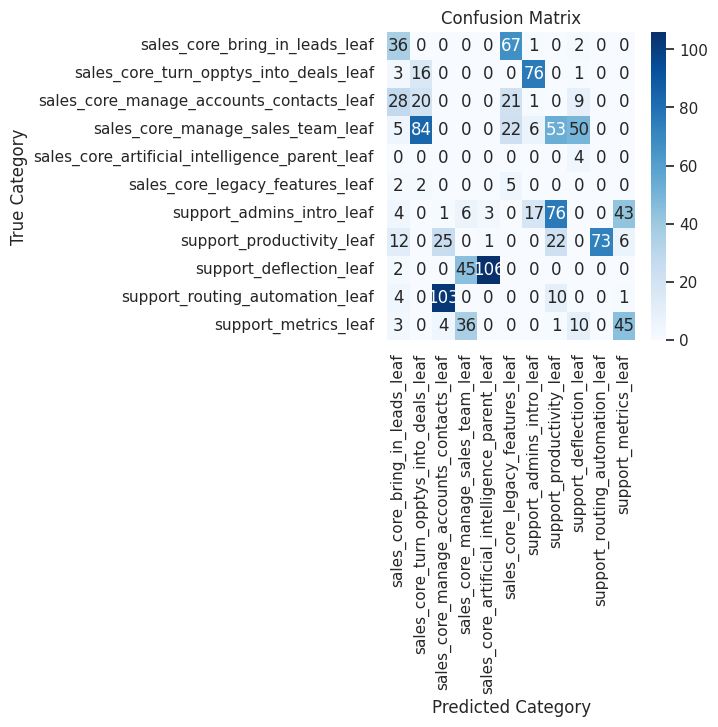

In [68]:
#Map labels to new label numbers
label_map_nmf_train = build_label_map(
                        true_label = true_label_txt,
                        pred_label = label_order_nmf_train,
                        LOD        = 1)
print()
#Map validate labels to new number lables
df_mapped_nmf_train = map_label_to_data(
                        label     = pd.DataFrame(yhat_nmf_train, columns = ['label']),
                        label_map = label_map_nmf_train,
                        LOD       = 1)
# Print out summary
cf_key, cf_matrix = display_confusion_matrix(
                        y_true    = y_train,
                        y_pred    = df_mapped_nmf_train['mapped_label'],
                        label_map = label_dict,
                        accuracy  = accuracy_nmf_train,
                        LOD       = 1)

In [69]:
label_map_nmf_train

{'sales_core_bring_in_leads_leaf': 2,
 'sales_core_turn_opptys_into_deals_leaf': 3,
 'sales_core_manage_accounts_contacts_leaf': 9,
 'sales_core_manage_sales_team_leaf': 5,
 'sales_core_artificial_intelligence_parent_leaf': 8,
 'sales_core_legacy_features_leaf': 0,
 'support_admins_intro_leaf': 1,
 'support_productivity_leaf': 6,
 'support_deflection_leaf': 4,
 'support_routing_automation_leaf': 7,
 'support_metrics_leaf': 10}

In [ ]:
print(label_map_nmf_train)
print(label_dict)

## Predict Test Data


In [ ]:
#invert label mapping dictionary
print('label mapping:', label_map_nmf_train)
inv_label_map_nmf_train = {v: k for k, v in label_map_nmf_train.items()}
print('inverted label mapping:', inv_label_map_nmf_train)

In [ ]:
# Function to predict the training data
def create_test_predictions_nmf(model_type, model, ft_t, df_t):
    yhat_test = predict(model.transform(ft_t))
    #join df_test with predicted labels
    df_test_pred = pd.DataFrame(df_t, columns=['label'])
    df_test_pred['label_pred'] = yhat_test

    return df_test_pred

In [ ]:
# Create test data prediction
df_test_nmf_pred = create_test_predictions_nmf(model_type = 'nmf', model = nmf_model,
                                          ft_t = X_val_tfidf, df_t = y_val)

display(df_test_nmf_pred)
# # X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test
# Columns in test set [data]: Index(['id', 'text', 'title', 'url', 'text length', 'word count', 'label', 'normalized text'],

## Model Results

**Score: 0.9551**

The Non-Negative Matrix Factorization (NMF) model had a maximum accuracy of 95.5%. This can be considered a very good accuracy for prediction.

# 8. Hyper Parameter Tuning of NMF

In [ ]:
# A function to execute test predicitons with a grid search approach
def quick_test_nmf(model_type, ft_train, df_train, ft_test, df_test, n_components, solver, beta_loss, label_dict):
    # Create the model
    nmf_model = NMF(
        n_components = n_components,
        solver       = solver,
        beta_loss    = beta_loss,
        random_state = 42)
    # Fit / Train the Model
    nmf_model.fit(ft_train)
    # Summarize model results
    yhat_nmf_train = predict(nmf_model.transform(ft_train))
    label_order_nmf_train, accuracy_nmf_train = label_permute_compare_fast(
                                                    ytdf = pd.DataFrame(df_train),
                                                    yp   = yhat_nmf_train,
                                                    label_dict = label_dict,
                                                    n    = len(label_dict),
                                                    LOD  = 0)
    # Print out the model labels and accuracy
    print('Accuracy :', round(accuracy_nmf_train,4))
    # Create test data prediction
    #df_test_rf_pred = create_test_predictions(model_type = model_type, model = nmf_model,
    #                                      ft_t = ft_test, df_t = df_test)

    return accuracy_nmf_train

In [ ]:
#quick_test_nmf(model_type = 'test',
#               ft_train = ft_train, df_train = df_train,
#               ft_test = ft_test, df_test = df_test,
#               n_components = 5,
#               solver = 'mu',
#               beta_loss = 'kullback-leibler')

In [ ]:
# Create tracking lists
grid_params = []
grid_acc = []

# define the parameters to test
set_n_components = list(range(2, 8, 1))
set_solver       = ['cd', 'mu']
set_beta_loss    = ['frobenius', 'kullback-leibler', 'itakura-saito']

# define the parameters to test
#set_n_components = list(range(4, 7, 1))
#set_solver       = ['mu']
#set_beta_loss    = ['kullback-leibler']

#iterate through parameters to test:
start_time = time.time()
for so in set_solver:
    for bl in set_beta_loss:
        for nc in set_n_components:
            elapsed_time = time.time() - start_time
            print('[.]','{:.0f}'.format(elapsed_time), 'seconds\t', 'solver:', so, '\tbeta_loss:', bl, '\tn_components:', str(nc), '\t||\t', end='')
            model_type = 'nmf_so_' + so + '_bl_' + bl + '_nc_' + str(nc).zfill(2)
            if(not((so=='cd' and bl == 'kullback-leibler') or
                   (so=='cd' and bl == 'itakura-saito') or
                   (so=='mu' and bl == 'itakura-saito')
                  )):
                acc = quick_test_nmf(model_type = model_type,
                                    ft_train = X_train_tfidf, df_train = y_train,
                                    ft_test = X_val_tfidf, df_test = y_val,
                                    n_components = nc, solver = so, beta_loss = bl, label_dict = label_dict)
                grid_params.append((so, bl, nc))
                grid_acc.append(acc)
            else:
                acc = 0.000
                print('Accuracy :', round(acc,4))
elapsed_time = time.time() - start_time
print('[.]','{:.0f}'.format(elapsed_time), 'seconds\t Process Completed.')

# # X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test

In [ ]:
x = [''.join(str(i)) for i in grid_params]
y = grid_acc
cols = ['tab:orange' if (x < 0) else 'tab:blue' for x in y]
sns.barplot(x=y,y=x, orient='h', hue=x, palette=cols, dodge=False, legend=False)

#add plot title
plt.title('Accuracy vs. Parameter Sets', fontsize=16)

#add axis labels
plt.xlabel('Accuracy')
plt.ylabel('Parameter Sets')

Based on analysis, the best fit is achieve with the following parameters:
- solver: mu
- beta_loss: kullback-leibler
- n_components: 5

This resulted in an optimized accuracy of 96.4% for the training dataset.

However, the most important parameter to set correctly is n_components = 5. This universally results in the best results, which makes sense because there are 5 categories to classify or cluster the data.

Otherwise we see that the kullback-leibler is slightly more accurate, but significantly slower for our data. For the final model, we should use the highest accuracy parameters, howver, for other parameter tuning excercises, we might consider using parameters of [solver: cd, beta_loss: frobenius, n_components: 5], which have a notably faster performance and an accuracy within about 1% (95.5% vs the best accuracy of 96.4%).

# 9. Final Model

# 10.&nbsp; Conclusions

### Results

**NVF Optimized Testing Result** =  96.4%

**Random Forest Optimized Testing Results** = 95.5%





### Model Comparison

Both processes are able to achieve similar results, with 95%+ accuracy for both optimized models. They both can work really well to achieve accuracy in predictions for the correct text category.

**Processing Speed**

To achieve the high perofrmance, the unsupervised model required parameter tuning that made the model run significantly slower. For the majority of the models test, the supervised learning random forest models was compartavely fasterthan the unsupervised learning mode.

Winner = Random Forest (Supervised)

**Tuning**

The random forest model required more hyperparameter tuning to achieve the results. Many parameters were needed for adjusting to ensure that the random forest model did not overfit to the training data. While it was easy to achieve 100% accuracy with the training data predictions, these models were overfitted. By setting limits on the Random Forest model with the Hyperparameters, the overfitting problem could be resolved, and training accuracy could mirror testing accuracy. It did however take additional tuning to get the performance of the random forest back up into the 90s. The unsupervised model was relatively easy to tune and most settings had good performance for testing and training.

Winner = NMF (Unsupervised)

**Overfitting**

The unserprivsied model does not struggle with overfitting issues. This is nice, b/c it mostly just works. The Random Forest supervised model struggles with overfitting, but can have these shortcomings mitigagated with the right selection of hyperparameters.

Winner = NMF (Unsupervised)

**Required Training**

The random forest did not require all the data and could achieve similar results with only 75% of the data used. The NMF model required all the data to train the model. This means that the random forest method can be considered more data efficient.

Winner = Random Forest (Supervised)

**Conclusions**

While both methods are effective, I find that the Random Forest model, and the Supervised Learning algorythems are likely more efficient at solving this problem. I would likely use a Random Forest for this problem in the future. Though, I do like the relative simplicity of the NMF model.

To further improve the accuracy of the model, additional supervised learning models, live SVM, could be explored to see if they have better performance. I think there might also be some more specific hyperparameter tuning that could be done on the random forest to squeeze a 1-2% points of accuracy, but you would have to consider the time investmestment vs. improvement to achieve this outcome.

# 11.&nbsp; References

**Competition**
- [1] BBC News Classification: News Articles Categorization https://www.kaggle.com/competitions/learn-ai-bbc/overview

**Documentation and References**
- [2] Lemmatization, https://en.wikipedia.org/wiki/Lemmatization
- [3] WordNet, https://en.wikipedia.org/wiki/WordNet
- [4] Natural Language Toolkit (NLTK), https://www.nltk.org/index.html
- [5] nltk.stem.wordnet, https://www.nltk.org/_modules/nltk/stem/wordnet.html
- [6] sklearn.feature_extraction.text.TfidfVectorizer, https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
- [7] sklearn.feature_extraction.text.CountVectorizer, https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
- [8] sklearn.feature_extraction.text.TfidfTransformer, https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#
- [9] sklearn.decomposition.NMF, https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
- [10] sklearn.ensemble.RandomForestClassifier, https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

**Other Kaggle Reports**
- [] Kaggle: bbc article classification https://www.kaggle.com/code/scrambledgabs/bbc-article-classification
- [] Kaggle: BBC News Classification https://www.kaggle.com/code/conradkleykamp/bbc-news-classification#Unsupervised-Model:-Matrix-Factorization-(NMF)
- [] Kaggle: Unsupervised - Matrix Factorization https://www.kaggle.com/code/mattison/unsupervised-matrix-factorization
- [] Kaggle: Make a Classification for BBC News BY LSTM https://www.kaggle.com/code/mohamedbakrey/make-a-classification-for-bbc-news-by-lstm